In [32]:
# imports
import pandas as pd
import seaborn as sns
from scipy import stats

In [423]:
df = pd.read_csv("../results/us-west-2-xlarge/read_12_58_7.out")

df_s = df[~df["action"].str.contains("read_trk")]
df_s

df_r = df[df["action"].str.contains("read_trk")]
df_r["storage"] = df["file"].apply(lambda x: "mem" if "BufferedReader" in x else "prefetch" if "Prefetch" in x else "s3fs")
df_r

df_s[["action", "runtime"]].groupby("action").mean()

<ipython-input-423-42942d279d67>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_r["storage"] = df["file"].apply(lambda x: "mem" if "BufferedReader" in x else "prefetch" if "Prefetch" in x else "s3fs")


,runtime
action,
read_mem,15.695370
read_prefetched,53.135072
read_s3fs,69.754215


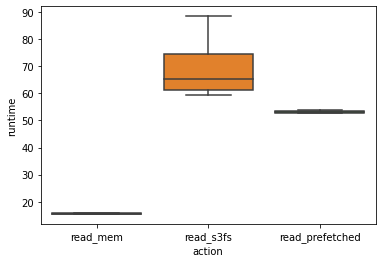

In [424]:
ax = sns.boxplot(x="action", y="runtime", data=df_s)

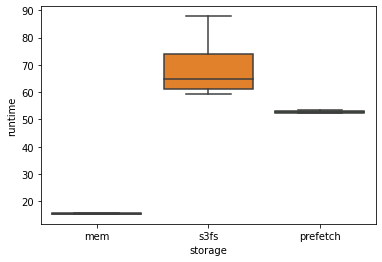

In [21]:
ax = sns.boxplot(x="storage", y="runtime", data=df_r)

,action,file,timestamp,runtime,lazy,blocksize,prefetch_storage
2,read_trk,"<File-like object S3FileSystem, hydi-tractogra...",98830936022482,87.824717,False,0,[]
3,read_s3fs,hydi-tractography/hydi_tracks.12_58_7.trk,98830407803437,88.353782,False,67108864,[]
10,read_trk,"<File-like object S3FileSystem, hydi-tractogra...",99041106104023,74.053603,False,0,[]
11,read_s3fs,hydi-tractography/hydi_tracks.12_58_7.trk,99040812480170,74.348037,False,67108864,[]
12,read_trk,"<File-like object S3FileSystem, hydi-tractogra...",99115438949876,61.027711,False,0,[]
13,read_s3fs,hydi-tractography/hydi_tracks.12_58_7.trk,99115160641762,61.307212,False,67108864,[]
20,read_trk,"<File-like object S3FileSystem, hydi-tractogra...",99298823693196,59.176732,False,0,[]
21,read_s3fs,hydi-tractography/hydi_tracks.12_58_7.trk,99298488522283,59.513063,False,67108864,[]
28,read_trk,"<File-like object S3FileSystem, hydi-tractogra...",99442924060808,64.877871,False,0,[]
29,read_s3fs,hydi-tractography/hydi_tracks.12_58_7.trk,99442553732015,65.248981,False,67108864,[]


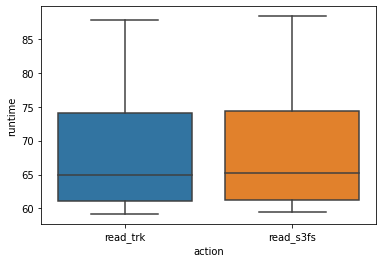

In [105]:
aws_dfs = df.loc[(df['action'] == "read_s3fs") | (df['file'].str.contains("S3File"))]

ax = sns.boxplot(x="action", y="runtime", data=aws_dfs)

aws_dfs

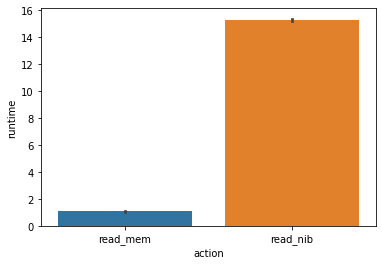

In [443]:
df = pd.read_csv("../results/us-west-2-xlarge/readmem_12_58_7.out")
ax = sns.barplot(x="action", y="runtime", data=df)

In [707]:
# model

def s3_read(n_b, l_f, l, f, b_s):
    latency = (n_b - 1)*l
    read_time = f/b_s
    return l_f + latency + read_time

def cache_read(n_b, l, f, b_mw, b_mr):
    latency = 2 * n_b * l
    b_mr /= 2
    b_mw /= 2
    read_time = 2*(f/b_mr)
    write_time = f/b_mw
    
    return latency + read_time + write_time

def prefetch(n_b, l, lm, f, b_s, b_mw, b_mr)

(0.04981141780153846,
 6.628054834436625e-05,
 5.6758883874863383e-05,
 90.63728020443301,
 141.92786973300073,
 2221.2483281148734)

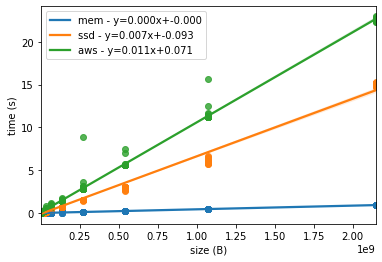

In [745]:
bdf = pd.read_csv("../results/us-west-2-xlarge/filetransferpy.bench")
bdf
# Get bandwidth
bdf["bw"] = bdf["size"] / bdf["time"]
aws_df = bdf[bdf["fs"] == "aws"]
local_df = bdf[bdf["fs"] == "local"]
mem_df = bdf[bdf["fs"] == "mem"]

aslope, aintercept, _, _, _ = stats.linregress(aws_df['size']/1024**2,aws_df['time'])
lslope, lintercept, _, _, _ = stats.linregress(local_df['size']/1024**2,local_df['time'])
mslope, mintercept, _, _, _ = stats.linregress(mem_df['size']/1024**2,mem_df['time'])

aws_bw = 1/aslope
local_bw = 1/lslope
mem_bw = 1/mslope

ax = sns.regplot(x="size", y="time", data=mem_df, line_kws={'label':"mem - y={0:.3f}x+{1:.3f}".format(mslope,mintercept)})
ax = sns.regplot(x="size", y="time", data=local_df, line_kws={'label':"ssd - y={0:.3f}x+{1:.3f}".format(lslope,lintercept)})
ax = sns.regplot(x="size", y="time", data=aws_df, line_kws={'label':"aws - y={0:.3f}x+{1:.3f}".format(aslope,aintercept)})

ax.set_xlabel("size (B)")
ax.set_ylabel("time (s)")
ax.legend()


aws_latency = aws_df[aws_df["size"] == 1024]["time"].mean()
ssd_latency = local_df[local_df["size"] == 1024]["time"].mean()
mem_latency = mem_df[mem_df["size"] == 1024]["time"].mean()
aws_latency, ssd_latency, mem_latency, aws_bw, local_bw, mem_bw

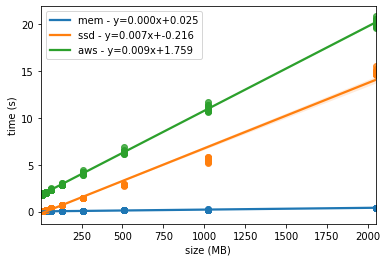

In [420]:
bdf = pd.read_csv("../results/us-west-2-xlarge/filetransfer.bench")
bdf
# Get bandwidth
bdf["bw"] = bdf["size"] / bdf["real"]
aws_df = bdf[bdf["fs"] == "aws"]
local_df = bdf[bdf["fs"] == "local"]
mem_df = bdf[bdf["fs"] == "mem"]

aslope, aintercept, _, _, _ = stats.linregress(aws_df['size'],aws_df['real'])
lslope, lintercept, _, _, _ = stats.linregress(local_df['size'],local_df['real'])
mslope, mintercept, _, _, _ = stats.linregress(mem_df['size'],mem_df['real'])

aws_bw = 1/aslope
local_bw = 1/lslope
mem_bw = 1/mslope

ax = sns.regplot(x="size", y="real", data=mem_df, line_kws={'label':"mem - y={0:.3f}x+{1:.3f}".format(mslope,mintercept)})
ax = sns.regplot(x="size", y="real", data=local_df, line_kws={'label':"ssd - y={0:.3f}x+{1:.3f}".format(lslope,lintercept)})
ax = sns.regplot(x="size", y="real", data=aws_df, line_kws={'label':"aws - y={0:.3f}x+{1:.3f}".format(aslope,aintercept)})

ax.set_xlabel("size (MB)")
ax.set_ylabel("time (s)")
ax.legend()

In [416]:
# model runtime predictions
import math
file_size = 2 * 1024
block_size = 2
n_b = file_size // block_size
n_f = 1
fr = 2.178922935873958
aws_latency = 9.975583085335756 * 10**-6
m_s3fs = s3_read(n_b, aws_latency, file_size, aws_bw)
m_prefetch = s3_read(n_b, aws_latency, file_size, aws_bw) + cache_read(n_b, mem_latency, file_size, mem_bw, mem_bw)
m_mem = n_b * abs(mem_latency) + file_size / mem_bw
m_s3fs, m_prefetch, m_mem, 2048/aws_bw, aws_bw

(20.592414021382822,
 22.93204106173556,
 0.3983612677995228,
 18.403276088429482,
 111.28453380578361)

In [134]:
df.groupby("action").mean()["runtime"].apply(lambda x: 1.7*1024 / x)
aws_df.mean()

repetition    9.500000e+00
size          3.721818e+02
time          4.266423e+00
blocksize     3.902609e+08
bw            7.469776e+01
dtype: float64

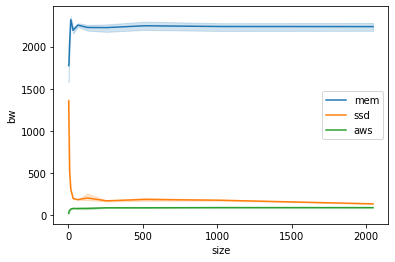

In [102]:
ax = sns.lineplot(x="size", y="bw", data=mem_df, label="mem")
ax = sns.lineplot(x="size", y="bw", data=local_df, label="ssd")
ax = sns.lineplot(x="size", y="bw", data=aws_df, label="aws")
ax.legend()

<AxesSubplot:xlabel='bs_mb', ylabel='time'>

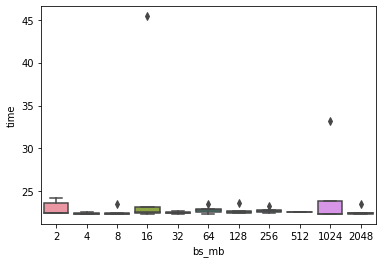

In [117]:
bs_df = pd.read_csv("../results/us-west-2-xlarge/blocksize_s3fs.bench")
bs_df["bs_mb"] = (bs_df["blocksize"] / 1024**2).astype(int)
sns.boxplot(x="bs_mb", y="time", data=bs_df)

''

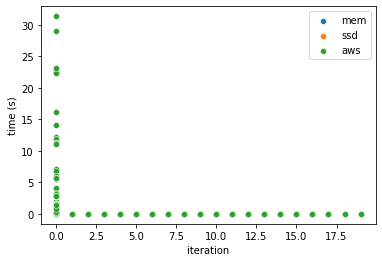

In [747]:
bdf = pd.read_csv("../results/us-west-2-xlarge/filetransfer-latency.bench")
bdf = bdf[bdf["action"].str.contains("read")]
bdf["iteration"] = bdf["action"].apply(lambda x: int(x.split("_")[-1]))

# Get bandwidth
#bdf["bw"] = bdf["size"] / bdf["time"]
aws_df = bdf[bdf["fs"] == "aws"]
local_df = bdf[bdf["fs"] == "local"]
mem_df = bdf[bdf["fs"] == "mem"]


ax = sns.scatterplot(x="iteration", y="time", data=mem_df, label="mem")
ax = sns.scatterplot(x="iteration", y="time", data=local_df, label="ssd")
ax = sns.scatterplot(x="iteration", y="time", data=aws_df, label="aws")

ax.set_xlabel("iteration")
ax.set_ylabel("time (s)")
ax.legend()
#mem_df[["iteration", "time"]].groupby("iteration").mean(), local_df[["iteration", "time"]].groupby("iteration").mean(),aws_df[["iteration", "time"]].groupby("iteration").mean()
, 

In [749]:
aws_fr = aws_df[aws_df["iteration"] == 0]["time"].mean()
#aws_latency = aws_df[aws_df["iteration"] == 0]["time"].mean()
aws_latency = aws_df[aws_df["iteration"] == 0]["time"].median()

mem_fr = mem_df[mem_df["iteration"] == 0]["time"].mean()
#mem_latency = mem_df[mem_df["iteration"] == 0]["time"].mean()
#mem_latency = mem_df["time"].median()

#ssd_fr = local_df[local_df["iteration"] == 0]["time"].mean()
#ssd_latency = local_df[local_df["iteration"] == 0]["time"].mean()
ssd_latency = local_df["time"].median()

n_f=1

m_s3fs = s3_read(n_b, aws_fr, aws_latency, file_size, aws_bw)
m_prefetch = s3_read(n_b, aws_fr, aws_latency, file_size, aws_bw) + cache_read(n_b, mem_latency, file_size, mem_bw, mem_bw)
m_mem = n_b * mem_fr + file_size / mem_bw

m_s3fs, m_prefetch, m_mem
aws_fr, mem_fr

(2.1741136439931075, 1.0363602433988654e-05)

In [377]:
block_sizes = list(total_df["blocksize"].drop_duplicates())
block_sizes.sort()
file_size = max(block_sizes)

aws_model = [s3_read(file_size//b, aws_latency, file_size // 1024**2, aws_bw) for b in block_sizes]
prefetch_model = [s3_read(file_size//b, aws_latency, file_size // 1024**2, aws_bw)
                  + cache_read(file_size//b, mem_latency, file_size // 1024**2, mem_bw, mem_bw)
                  for b in block_sizes]
#aws_model, file_size, aws_latency, file_size, aws_bw, aws_fr

#b_df[b_df["blocksize"] == 1048576][b_df["action"].str.contains("read")][b_df["fs"] == "aws"].groupby("action").mean()
#aws_model = [(file_size//b)*aws_fr + (file_size // 1024**2)/aws_bw for b in block_sizes]
aws_model, prefetch_model
zip(block_sizes, aws_model, prefetch_model)

model_df = pd.DataFrame(zip(block_sizes, aws_model, prefetch_model), columns=["blocksize", "aws", "pf"])
model_df

,blocksize,aws,pf
0,1048576,115.448253,117.813151
1,2097152,68.015226,70.354853
2,4194304,44.298713,46.625704
3,8388608,32.440456,34.761130
4,16777216,26.511327,28.828843
5,33554432,23.546763,25.862699
6,67108864,22.064481,24.379628
7,134217728,21.323340,23.638092
8,268435456,20.952770,23.267324
9,536870912,20.767484,23.081940


<ipython-input-444-5dba1fca86be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df["blocksize (MB)"] = total_df["blocksize"] // 1024**2


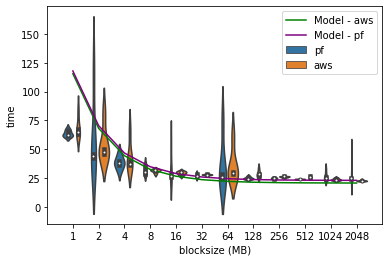

In [444]:
from matplotlib import pyplot as plt
b_df = pd.read_csv("../results/us-west-2-xlarge/blocksize_s3fs.bench")
total_df = b_df[b_df["action"] == "total"]
total_df["blocksize (MB)"] = total_df["blocksize"] // 1024**2

merge_df = pd.merge(total_df, model_df, on=["blocksize"])
fig, ax = plt.subplots()
ax = sns.violinplot(x="blocksize (MB)", y="time", hue="fs", data=total_df, ax=ax)
ax = sns.lineplot(x=[i for i in range(len(block_sizes))], y="aws", data=model_df, ax=ax, color="green", label="Model - aws")
ax = sns.lineplot(x=[i for i in range(len(block_sizes))], y="pf", data=model_df, ax=ax, color="purple", label="Model - pf")

#merge_df[merge_df["blocksize (MB)"] == 1]

<ipython-input-408-dee1c27af1f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df["blocksize (MB)"] = total_df["blocksize"] // 1024**2


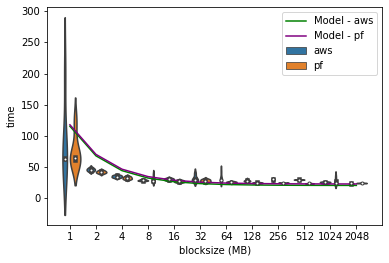

In [408]:
from matplotlib import pyplot as plt

b_df = pd.read_csv("../results/us-west-2-xlarge/blocksize_s3fs-read_size.bench")
total_df = b_df[b_df["action"] == "total"]
total_df["blocksize (MB)"] = total_df["blocksize"] // 1024**2

fig, ax = plt.subplots()
ax = sns.violinplot(x="blocksize (MB)", y="time", hue="fs", data=total_df, ax=ax)
ax = sns.lineplot(x=[i for i in range(len(block_sizes))], y="aws", data=model_df, ax=ax, color="green", label="Model - aws")
ax = sns.lineplot(x=[i for i in range(len(block_sizes))], y="pf", data=model_df, ax=ax, color="purple", label="Model - pf")

In [442]:
total_data = 26029411136 / 1024**2
block_size = 64
nb = total_data//block_size
m_s3fs = s3_read(nb, aws_latency, total_data, aws_bw)
m_prefetch = s3_read(nb, aws_latency, total_data, aws_bw) + cache_read(nb, mem_latency, total_data, mem_bw, mem_bw)
m_mem = nb * mem_fr + total_data / mem_bw

m_s3fs,m_prefetch,m_mem, 15 * 20, total_data, nb, aws_latency

(293.9835351084903,
 361.04614001060395,
 11.180408339369432,
 300,
 24823.58087158203,
 387.0,
 0.04632131551625205)

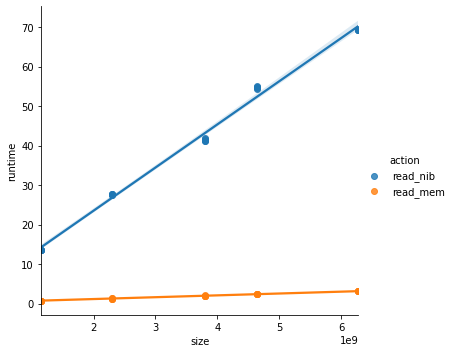

In [487]:
n_df = pd.read_csv("../results/us-west-2-xlarge/readmem.out", quoting=2)
n_df["n_files"] = n_df["file"].apply(lambda x: len(x.split(',')))

from s3fs import S3FileSystem
from os import path as op
import ast
fs = S3FileSystem()
files = ast.literal_eval(list(n_df[["file", "n_files"]].sort_values(by="n_files", ascending=False)["file"].head(1))[0])

sizes = [fs.du(op.join("hydi-tractography", op.basename(f))) for f in files]

n_df["size"] = n_df["n_files"].apply(lambda x: sum(sizes[0:x]))

sns.lmplot(x="size", y="runtime", hue="action", data=n_df)

In [496]:
nslope, nintercept, _, _, _ = stats.linregress(n_df[n_df["action"] == "read_nib"]['size'],n_df[n_df["action"] == "read_nib"]['runtime'])
bslope, bintercept, _, _, _ = stats.linregress(n_df[n_df["action"] == "read_mem"]['size'],n_df[n_df["action"] == "read_mem"]['runtime'])
nslope

(1.0941752085023074e-08, 4.682797991190695e-10)

In [507]:
f20_compute = nslope * 26029411136
f20_compute

284.8073635692508

/home/valeriehayot/Documents/code/ariel_internship/rollingprefetch/.venv/lib64/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,action,runtime
20,read_s3fs,1381.848613
22,read_prefetched,1094.510514
24,read_prefetched,1075.331384
45,read_s3fs,1490.029191
66,read_s3fs,1414.754272
68,read_prefetched,1054.571877
89,read_s3fs,1437.219286
91,read_prefetched,1076.486148
93,read_prefetched,1063.927292
114,read_s3fs,1360.817403


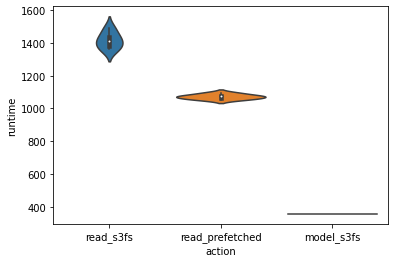

In [574]:
r_df = pd.read_csv("../results/us-west-2-xlarge/read_20f.out", quoting=2)
r_df = r_df[r_df["action"] != "read_trk"][["action", "runtime"]]

r_df = pd.concat([r_df, pd.DataFrame([("model_s3fs", f20_compute + m_s3fs)], columns=["action", "runtime"])])

sns.violinplot(r_df["action"], r_df["runtime"])
r_df

In [524]:
fs.invalidate_cache()
f_50 = fs.glob("hydi-tractography/hydi_*")[0:50]
size_50f = [fs.du(f) for f in f_50]

In [534]:
total_data = sum(size_50f) // 1024**2
bs = 64
nb = total_data//bs
ms3fs = s3_read(nb, aws_latency, total_data, aws_bw)
ms3fs + nslope*sum(size_50f), ms3fs

(1583.4240238581128, 802.433955828307)

In [536]:
size_5f = size_50f[0:5]
total_data = sum(size_5f) // 1024**2
bs = 64
nb = total_data//bs
ms3fs_5 = s3_read(nb, aws_latency, total_data, aws_bw)
ms3fs_5 + nslope*sum(size_50f), ms3fs

(853.4762058847302, 802.433955828307)

/home/valeriehayot/Documents/code/ariel_internship/rollingprefetch/.venv/lib64/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 5000.0)

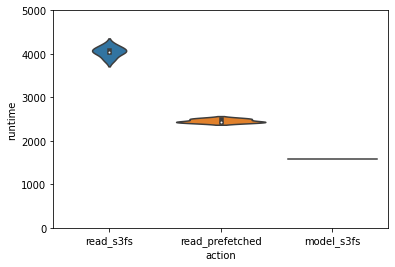

In [535]:
r_df = pd.read_csv("../results/us-west-2-xlarge/read_50f.out", quoting=2)
r_df = r_df[r_df["action"] != "read_trk"][["action", "runtime"]]

r_df = pd.concat([r_df, pd.DataFrame([("model_s3fs", ms3fs + nslope*sum(size_50f))], columns=["action", "runtime"])])

sns.violinplot(r_df["action"], r_df["runtime"])
plt.ylim([0, 5000])

/home/valeriehayot/Documents/code/ariel_internship/rollingprefetch/.venv/lib64/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 1000.0)

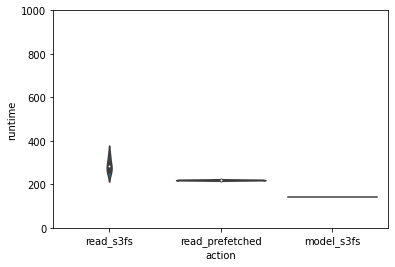

In [538]:
r_df = pd.read_csv("../results/us-west-2-xlarge/read_5f_nolazy.out", quoting=2)
r_df = r_df[r_df["action"] != "read_trk"][["action", "runtime"]]

r_df = pd.concat([r_df, pd.DataFrame([("model_s3fs", ms3fs_5 + nslope*sum(size_5f))], columns=["action", "runtime"])])

sns.violinplot(r_df["action"], r_df["runtime"])
plt.ylim([0, 1000])

In [ ]:
# Experiment 2 

<AxesSubplot:xlabel='size', ylabel='runtime'>

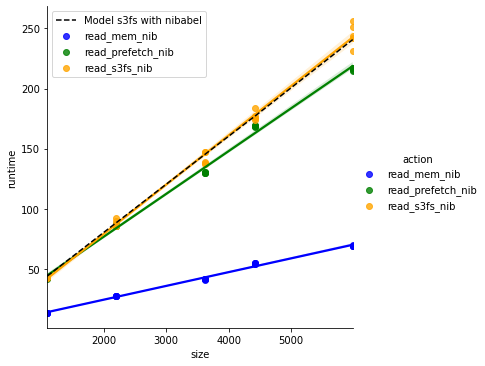

In [744]:
# Experiment 3

n_df = pd.read_csv("../results/us-west-2-xlarge/exp-3/readcmp-1-5f.out", quoting=2)
n_df["n_files"] = n_df["file"].apply(lambda x: len(x.split(',')))
n_df = n_df[n_df["action"].str.contains("nib")]

from s3fs import S3FileSystem
from os import path as op
import ast
fs = S3FileSystem()
files = ast.literal_eval(list(n_df[n_df["action"].str.contains("s3fs")][["file", "n_files"]] \
                              .sort_values(by="n_files", ascending=False)["file"].head(1))[0])

sizes = [fs.du(op.join("hydi-tractography", op.basename(f))) for f in files]

#n_df.loc[n_df["action"].str.contains("prefetch"), "n_files"] -= 1
n_df["size"] = 0
n_df.loc[~n_df["action"].str.contains("prefetch"), "size"] = n_df[~n_df["action"]
                                                                  .str
                                                                  .contains("prefetch")]["n_files"] \
                                                            .apply(lambda x: sum(sizes[0:x])/1024**2)
n_df.loc[n_df["action"].str.contains("prefetch"), "size"] = n_df[n_df["action"]
                                                                 .str
                                                                 .contains("prefetch")]["n_files"] \
                                                            .apply(lambda x: sum(sizes[0:x-1])/1024**2)


n_df = n_df.sort_values(by="action").reset_index()
ms3fs_bytes = [(s3_read(1, aws_fr, aws_latency, (sum(sizes[:i])/1024**2), aws_bw)) for i in range(1, 6)]
# ms3fs_nib = [(s3_read((sum(sizes[:i])/ 1024**2)//bs, aws_latency, (sum(sizes[:i])/1024**2), aws_bw)
#               + max(nslope*sum(sizes[:i]), (60/(1.7*1024**3))*sum(sizes[:i]))) 
#               for i in range(1, 6)]
ms3fs_nib = [(s3_read((sum(sizes[:i])/ 1024**2)//bs, 1.14, 1.14, (sum(sizes[:i])/1024**2), aws_bw)
              + nslope*sum(sizes[:i])) 
              for i in range(1, 6)]

sum_sizes = [sum(sizes[:i])/ 1024**2 for i in range(1,6)]
#print(sum_sizes)
#print(ms3fs_bytes)
sns.lmplot(x="size", y="runtime", hue="action", palette=["blue", "green", "orange"], data=n_df)
#sns.lineplot(x=sum_sizes, y=ms3fs_bytes, linestyle="-.", color="black", label="Model s3fs bytes")
sns.lineplot(x=sum_sizes, y=ms3fs_nib, linestyle="--", color="black", label="Model s3fs with nibabel")
#n_df

#split figure into 2 1 for each model.
# go until 20files

In [751]:
ms3fs_size = [(s3_read((sum(sizes[:i])/ 1024**2)//bs, aws_fr, aws_latency, (sum(sizes[:i])/1024**2), aws_bw) + nslope*sum(sizes[:i])) for i in range(1, 6)]
#ms3fs_size
n_df.sort_values(by="size")[n_df["action"].str.contains("s3fs")]
((sum(sizes[0:2])/(64*1024**2))-1)*aws_fr + nslope*sum(sizes[0:2])
sorted(sizes)

<ipython-input-751-d07019a2be95>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_df.sort_values(by="size")[n_df["action"].str.contains("s3fs")]


[831553824, 1148092216, 1149923680, 1500068420, 1643970400]

(0.0, 4500.0)

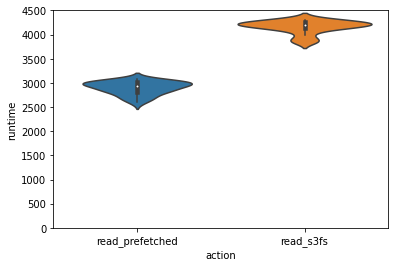

In [627]:
## Experiment 4

import glob

pf = glob.glob("../results/us-west-2-xlarge/exp-4/*prefetch*")
sf = glob.glob("../results/us-west-2-xlarge/exp-4/*s3fs*")

df_p = pd.concat((pd.read_csv(f).assign(rep=int(f.split("_")[-1].split(".")[0])) for f in pf), ignore_index=True)
df_p = df_p[~df_p["action"].str.contains("trk")][["action", "rep", "runtime"]]#.groupby("rep").max("runtime")
#df_p["fs"] = ""

df_s = pd.concat((pd.read_csv(f).assign(rep=int(f.split("_")[-1].split(".")[0])) for f in sf), ignore_index=True)
df_s = df_s[~df_s["action"].str.contains("trk")][["action", "rep", "runtime"]]#.groupby("rep").max("runtime")
#df_s["fs"] = "s3fs"

df_pa = pd.concat([df_p, df_s], ignore_index=True)

#sns.viol

ax = sns.violinplot(x="action", y="runtime", data=df_pa)
plt.ylim(0, 4500)
# no parallelism vs with (some) parallelism


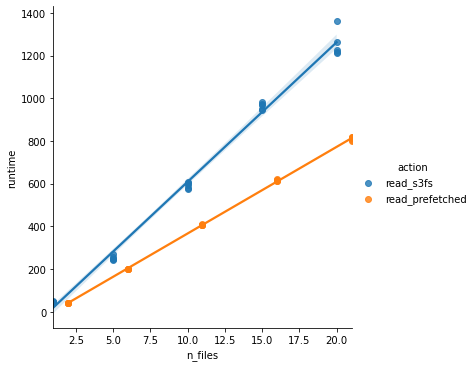

In [664]:
files = glob.glob("../results/us-west-2-xlarge/exp-2/*")

df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
df["n_files"] = df["file"].apply(lambda x: len(ast.literal_eval(x)))
#df[[df"action"]]

sns.lmplot(x="n_files", y="runtime", hue="action", data=df)


0      32.0
2       0.0
15    128.0
30     16.0
45      8.0
61     64.0
Name: blocksize, dtype: float64

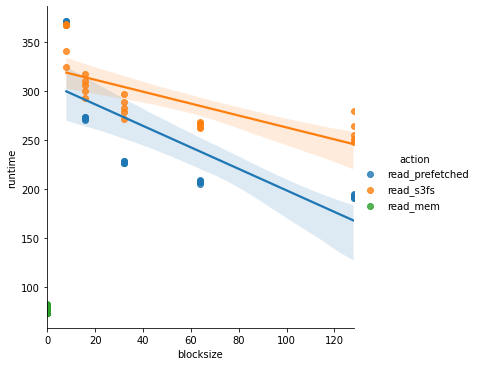

In [715]:
files = glob.glob("../results/us-west-2-xlarge/exp-1/*")

df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
#df["n_files"] = df["file"].apply(lambda x: len(ast.literal_eval(x)))
#df[[df"action"]]
df["blocksize"] = df["blocksize"] / 1024**2

sns.lmplot(x="blocksize", y="runtime", hue="action", data=df)
df["blocksize"].drop_duplicates()

In [753]:
nslope * 1500068420

16.41337676221227

In [755]:
nintercept

1.6135451408742156